In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from google.cloud import aiplatform
from datetime import datetime
import joblib
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [21]:
from sklearn.compose import ColumnTransformer

In [22]:
def select_features(X_train, y_train, X_test, feature_names, k=30):
    """
    Select top k features using ANOVA F-value
    
    Parameters:
    X_train: numpy array of scaled training features
    y_train: numpy array of training target
    X_test: numpy array of scaled test features
    feature_names: list of original feature names
    k: number of top features to select
    """
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # Get selected feature names using the original feature names
    selected_features = [feature_names[i] for i in selector.get_support(indices=True)]
    
    return X_train_selected, X_test_selected, selected_features

# Get feature names before scaling (when X_train is still a DataFrame)
feature_names = X_train.columns.tolist()

# Select top 30 features (adjust based on your needs)
X_train_selected, X_test_selected, selected_features = select_features(
    X_train_scaled, y_train_res, X_test_scaled, feature_names, k=30
)

print("Selected Features:")
print(selected_features)

Selected Features:
['Capacity Utilization : Manufacturing', 'Average Duration of Unemployment ( Weeks )', 'Civilians Unemployed - Less Than 5 Weeks', 'Initial Claims', 'All Employees : Mining and Logging : Mining', 'Avg Weekly Hours : Goods - Producing', 'Avg Weekly Overtime Hours : Manufacturing', 'Avg Weekly Hours Manufacturing', 'Housing Starts : Total New Privately Owned', "S & P's Composite Common Stock : Dividend Yield", "S & P's Composite Common Stock : Price - Earnings Ratio", 'Effective Federal Funds Rate', '3 - Month AA Financial Commercial Paper Rate', '3 - Month Treasury Bill :', '6 - Month Treasury Bill :', '1 - Year Treasury Rate', '5 - Year Treasury Rate', '10 - Year Treasury Rate', "Moody's Seasoned Aaa Corporate Bond Yield", "Moody's Seasoned Baa Corporate Bond Yield", '3 - Month Commercial Paper Minus FEDFUNDS', '3 - Month Treasury C Minus FEDFUNDS', '6 - Month Treasury C Minus FEDFUNDS', '1 - Year Treasury C Minus FEDFUNDS', '5 - Year Treasury C Minus FEDFUNDS', '10 

In [24]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train_res:", y_train_res.shape)

Shape of X_train: (207, 96)
Shape of y_train_res: (364,)


Scikit-learn version after potential install: 1.5.2

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        45
         1.0       1.00      0.71      0.83         7

    accuracy                           0.96        52
   macro avg       0.98      0.86      0.91        52
weighted avg       0.96      0.96      0.96        52



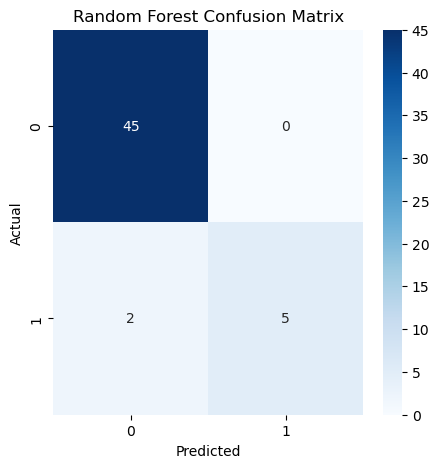


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        45
         1.0       1.00      0.86      0.92         7

    accuracy                           0.98        52
   macro avg       0.99      0.93      0.96        52
weighted avg       0.98      0.98      0.98        52



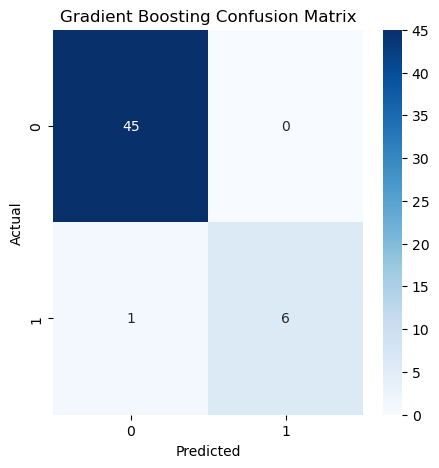


XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        45
         1.0       1.00      1.00      1.00         7

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



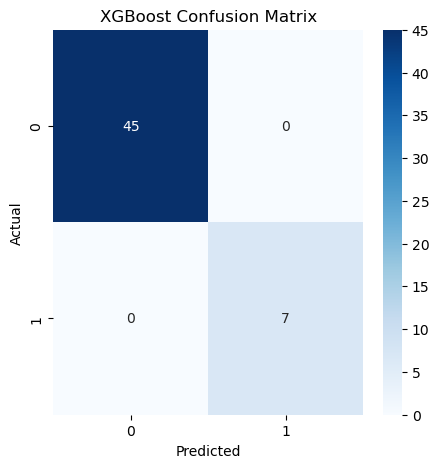


Model Comparison:

Random Forest:
accuracy: 0.9615
precision: 1.0000
recall: 0.7143
f1: 0.8333
roc_auc: 1.0000

Gradient Boosting:
accuracy: 0.9808
precision: 1.0000
recall: 0.8571
f1: 0.9231
roc_auc: 0.9286

XGBoost:
accuracy: 1.0000
precision: 1.0000
recall: 1.0000
f1: 1.0000
roc_auc: 1.0000
✅ Full pipeline saved as vertex_model.joblib
✅ Pipeline uploaded to gs://us-recession-model/vertex_model.joblib


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from google.cloud import aiplatform
from datetime import datetime
import joblib
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

from sklearn.compose import ColumnTransformer

# **After installing the compatible version, run this again to verify:**
import sklearn
print(f"Scikit-learn version after potential install: {sklearn.__version__}")

# Load the dataset
data = pd.read_excel('US_Recession.xlsx')  # Update with your actual file path

if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

# Preprocess the data
def preprocess_data(df):
    df_processed = df.copy()
    df_processed.fillna(method='ffill', inplace=True)
    df_processed.fillna(method='bfill', inplace=True)
    if 'gdp_growth' in df.columns:
        for lag in [1, 2, 4]:
            df_processed[f'gdp_growth_lag_{lag}'] = df_processed['gdp_growth'].shift(lag)
    if 'unemployment_rate' in df.columns:
        df_processed['unemployment_change'] = df_processed['unemployment_rate'].diff()
    if 'industrial_production' in df.columns:
        df_processed['industrial_prod_rolling_mean_4q'] = (
            df_processed['industrial_production'].rolling(window=4).mean()
        )
    df_processed.dropna(inplace=True)
    return df_processed

processed_data = preprocess_data(data)
X = processed_data.drop('recession_indicator', axis=1)
y = processed_data['recession_indicator']
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_scaled_res = scaler.fit_transform(X_train_res) # Scale the resampled training data
X_test_scaled = scaler.transform(X_test)

def select_features(X_train, y_train, X_test, feature_names, k=30):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    selected_features_indices = selector.get_support(indices=True)
    selected_features = [feature_names[i] for i in selected_features_indices]
    return X_train_selected, X_test_selected, selected_features, selected_features_indices

feature_names = X_train.columns.tolist() # Original feature names

# Select features based on the scaled resampled training data and resampled target
X_train_selected_res, X_test_selected, selected_features, selected_features_indices = select_features(
    X_train_scaled_res, y_train_res, X_test_scaled, feature_names, k=30
)

def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42),
        'XGBoost': XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05, objective='binary:logistic', random_state=42, scale_pos_weight=sum(y_train==0)/sum(y_train==1))
    }
    best_model = None
    best_score = 0.0
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train) # Use X_train_selected_res here
        y_pred = model.predict(X_test) # Use X_test_selected here
        y_prob = model.predict_proba(X_test)[:, 1] # Use X_test_selected here
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)
        results[name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc}
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        if roc_auc > best_score:
            best_score = roc_auc
            best_model = model
    print("\nModel Comparison:")
    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")
    return best_model

# Train and evaluate models using the selected resampled data
best_model = train_and_evaluate_models(X_train_selected_res, y_train_res, X_test_selected, y_test)

# Create the full pipeline with the *fitted* scaler and feature selector
full_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        [('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', scaler)]),
          selected_features)],
        remainder='passthrough'
    )),
    ('model', best_model)
])

# **FIT THE PIPELINE TO THE SCALED AND SELECTED RESAMPLED TRAINING DATA:**
full_pipeline.fit(X_train_res.iloc[:, selected_features_indices], y_train_res)

# Save the *entire* fitted pipeline
joblib.dump(full_pipeline, 'vertex_model.joblib')
print("✅ Full pipeline saved as vertex_model.joblib")

# Upload the pipeline to GCS
from google.cloud import storage
client = storage.Client.from_service_account_json(
    r"C:/Users/rudra.s/Downloads/spry-scope-456205-m7-be989ff0ac36.json"
)
blob = client.bucket('us-recession-model').blob('vertex_model.joblib')
blob.upload_from_filename('vertex_model.joblib', content_type='application/joblib')
print("✅ Pipeline uploaded to gs://us-recession-model/vertex_model.joblib")

In [32]:
pip install scikit-learn==1.5.2

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.0 MB 8.5 MB/s eta 0:00:02
   ----- ---------------------------------- 1.6/11.0 MB 4.2 MB/s eta 0:00:03
   -------- ------------------------------- 2.4/11.0 MB 4.5 MB/s eta 0:00:02
   ---------- ----------------------------- 2.9/11.0 MB 4.1 MB/s eta 0:00:02
   ------------- -------------------------- 3.7/11.0 MB 3.5 MB/s eta 0:00:03
   --------------- ------------------------ 4.2/11.0 MB 3.8 MB/s eta 0:00:02
   ----------------- ---------------------- 4.7/11.0 MB 3.6 MB/s eta 0:00:02
   -------------------- ------------------- 5.5/11.0 MB 3.5 MB/s eta 0:00:02
   ------------------------ --------------- 6.8/11.0 MB 3.6 MB/s eta 0:00:02
   --------------------------- ------------ 7.6/11.0 MB 3.6 MB/s eta 0:00:01
   -------------------------------- ------- 8.9/11.0 MB 3.8 MB/s eta 0:00:01
   ------------------------------------ --- 10.0/11.0 MB 4.0 MB/s eta 0:00:01
   --

  You can safely remove it manually.
